In [49]:
import numpy as np
import pandas as pd
import math
import codecs
import spacy
import json
import re

import umap
import matplotlib.pyplot as plt

from wordcloud import WordCloud, get_single_color_func
from PIL import Image, ImageDraw

import textacy
import textacy.tm
import textacy.preprocessing

from functools import partial

from pointgrid import align_points_to_grid


In [50]:
df = pd.read_csv('metadata.csv')
df.head(1)

,authors,organisations,title_plain,keywords,topics,tg1_Language,tg3_Geography,tg2_Temporal,tg4_Methods,tg5_Disciplines_Fields_of_Study,Abstract,all_emails,acceptance
0,"Aboelnagah, Hadeer","Prince Sultan University, Saudi Arabia",Building Online Communities as a Platform for ...,"Blogging, Collaborative Creativity, Sharing Kn...","Asia, Global, English, Contemporary, curricula...",English,"Asia, Global",Contemporary,curricular and pedagogical development and ana...,"Cultural studies, Education/ pedagogy",Digital Humanities as an emerging field provid...,habouelnagah@psu.edu.sa,Lightning


In [51]:
preproc = textacy.preprocessing.make_pipeline(
    textacy.preprocessing.normalize.unicode,
    textacy.preprocessing.normalize.quotation_marks,
    textacy.preprocessing.normalize.whitespace,
    textacy.preprocessing.remove.brackets
)

authors = []
texts = []

# for index, row in xlsx.iterrows():
for index, row in df.iterrows():

    if row['tg1_Language'] != 'English':
        continue # Filter English articles

    _a = row['authors'] # Authors
    _a = re.sub(r'\([^()]*\)', '', _a) # remove brackets
    _k = row['keywords'] # Keywords
    _t = row['Abstract'] # Text
    _t = preproc(_t) # Preprocessing

    # Save texts by author
    
    for a in _a.split("; "):

        a = a.rstrip().lstrip() # remove first and end spaces

        if a in authors:
            i = authors.index(a)
            texts[i] = texts[i] + ' ' + _t

        else:
            authors.append(a)
            texts.append(_t)

len(authors), len(texts)

(1055, 1055)

In [52]:
# Parsing

en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
# en = textacy.load_spacy_lang("en_core_web_lg", disable=("parser",))
# en = textacy.load_spacy_lang("en_core_web_trf", disable=("parser",))

docs = []

for index, text in enumerate(texts):
    
    doc = textacy.make_spacy_doc(text, lang=en)
    docs.append(doc)
    print(index, end=' ')

    # doc = nlp(text)
    # print(doc._.preview)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [105]:
# Lematization

stopwords = {}

lemmas = []

# ngs = partial(textacy.extract.ngrams, n=[1, 2], include_pos={'ADJ', 'NOUN'})
ngs = partial(textacy.extract.ngrams, n=[1], include_pos={"NOUN"})
# ents = partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"})

for doc in docs:
    # extraction = textacy.extract.keyterms.textrank(doc, normalize='lemma')
    extraction = textacy.extract.terms(doc, ngs=ngs)
    # extraction = textacy.extract.basics.words(doc, filter_stops=True, filter_nums=True)
    lemmatization = textacy.extract.terms_to_strings(extraction, by="lemma")
    
     # Remove strings containing stopwords
    lemmatization = [l for l in lemmatization if not any(stopword in l for stopword in stopwords)]
    
    for index, l in enumerate(lemmatization):
        if 'datum' in l : lemmatization[index] = l.replace('datum', 'data')
        if 'medium' in l : lemmatization[index] = l.replace('medium', 'media')
        
    lemmas.append(list(lemmatization))

# TF-IDF

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(lemmas, tf_type="linear", idf_type="smooth")

doc_term_matrix


<1055x4105 sparse matrix of type '<class 'numpy.float64'>'
	with 82800 stored elements in Compressed Sparse Row format>

topic 0: sustainability  software  project
topic 1: recording  scenario  metadata
topic 2: replication  study  seed
topic 3: newspaper  collection  data
topic 4: student  justice  dh


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/textacy/tm/topic_model.py:210: RuntimeWarning: invalid value encountered in true_divide
  return doc_topic_matrix / np.sum(doc_topic_matrix, axis=1, keepdims=True)


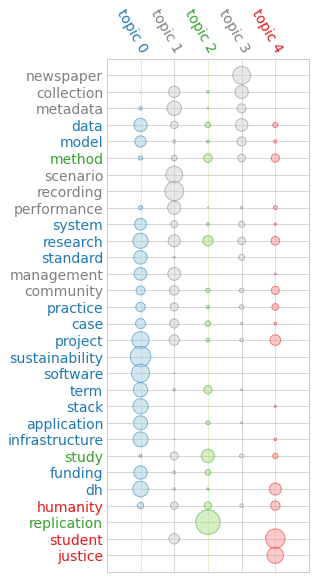

In [106]:
# import textacy
# from textacy.vsm import Vectorizer

model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

dictionary_inverted = {id: term for term, id in dictionary.items()}

import operator

topics = []

for doc in model.get_doc_topic_matrix(doc_term_matrix):
    index, value = max(enumerate(doc), key=operator.itemgetter(1))
    # print(index, doc)
    topics.append(index)

# for weight in model.topic_weights(doc_topic_matrix):
#     print(doc)
for topic_idx, terms in model.top_topic_terms(dictionary_inverted, top_n=3):
    print(f"topic {topic_idx}: {'  '.join(terms)}")
# for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
#      print(i, val)

model.termite_plot(doc_term_matrix, dictionary_inverted, n_terms=30, highlight_topics=[0,2,4,6,8,10])

 * creating mesh with size 103 103
 * filling mesh


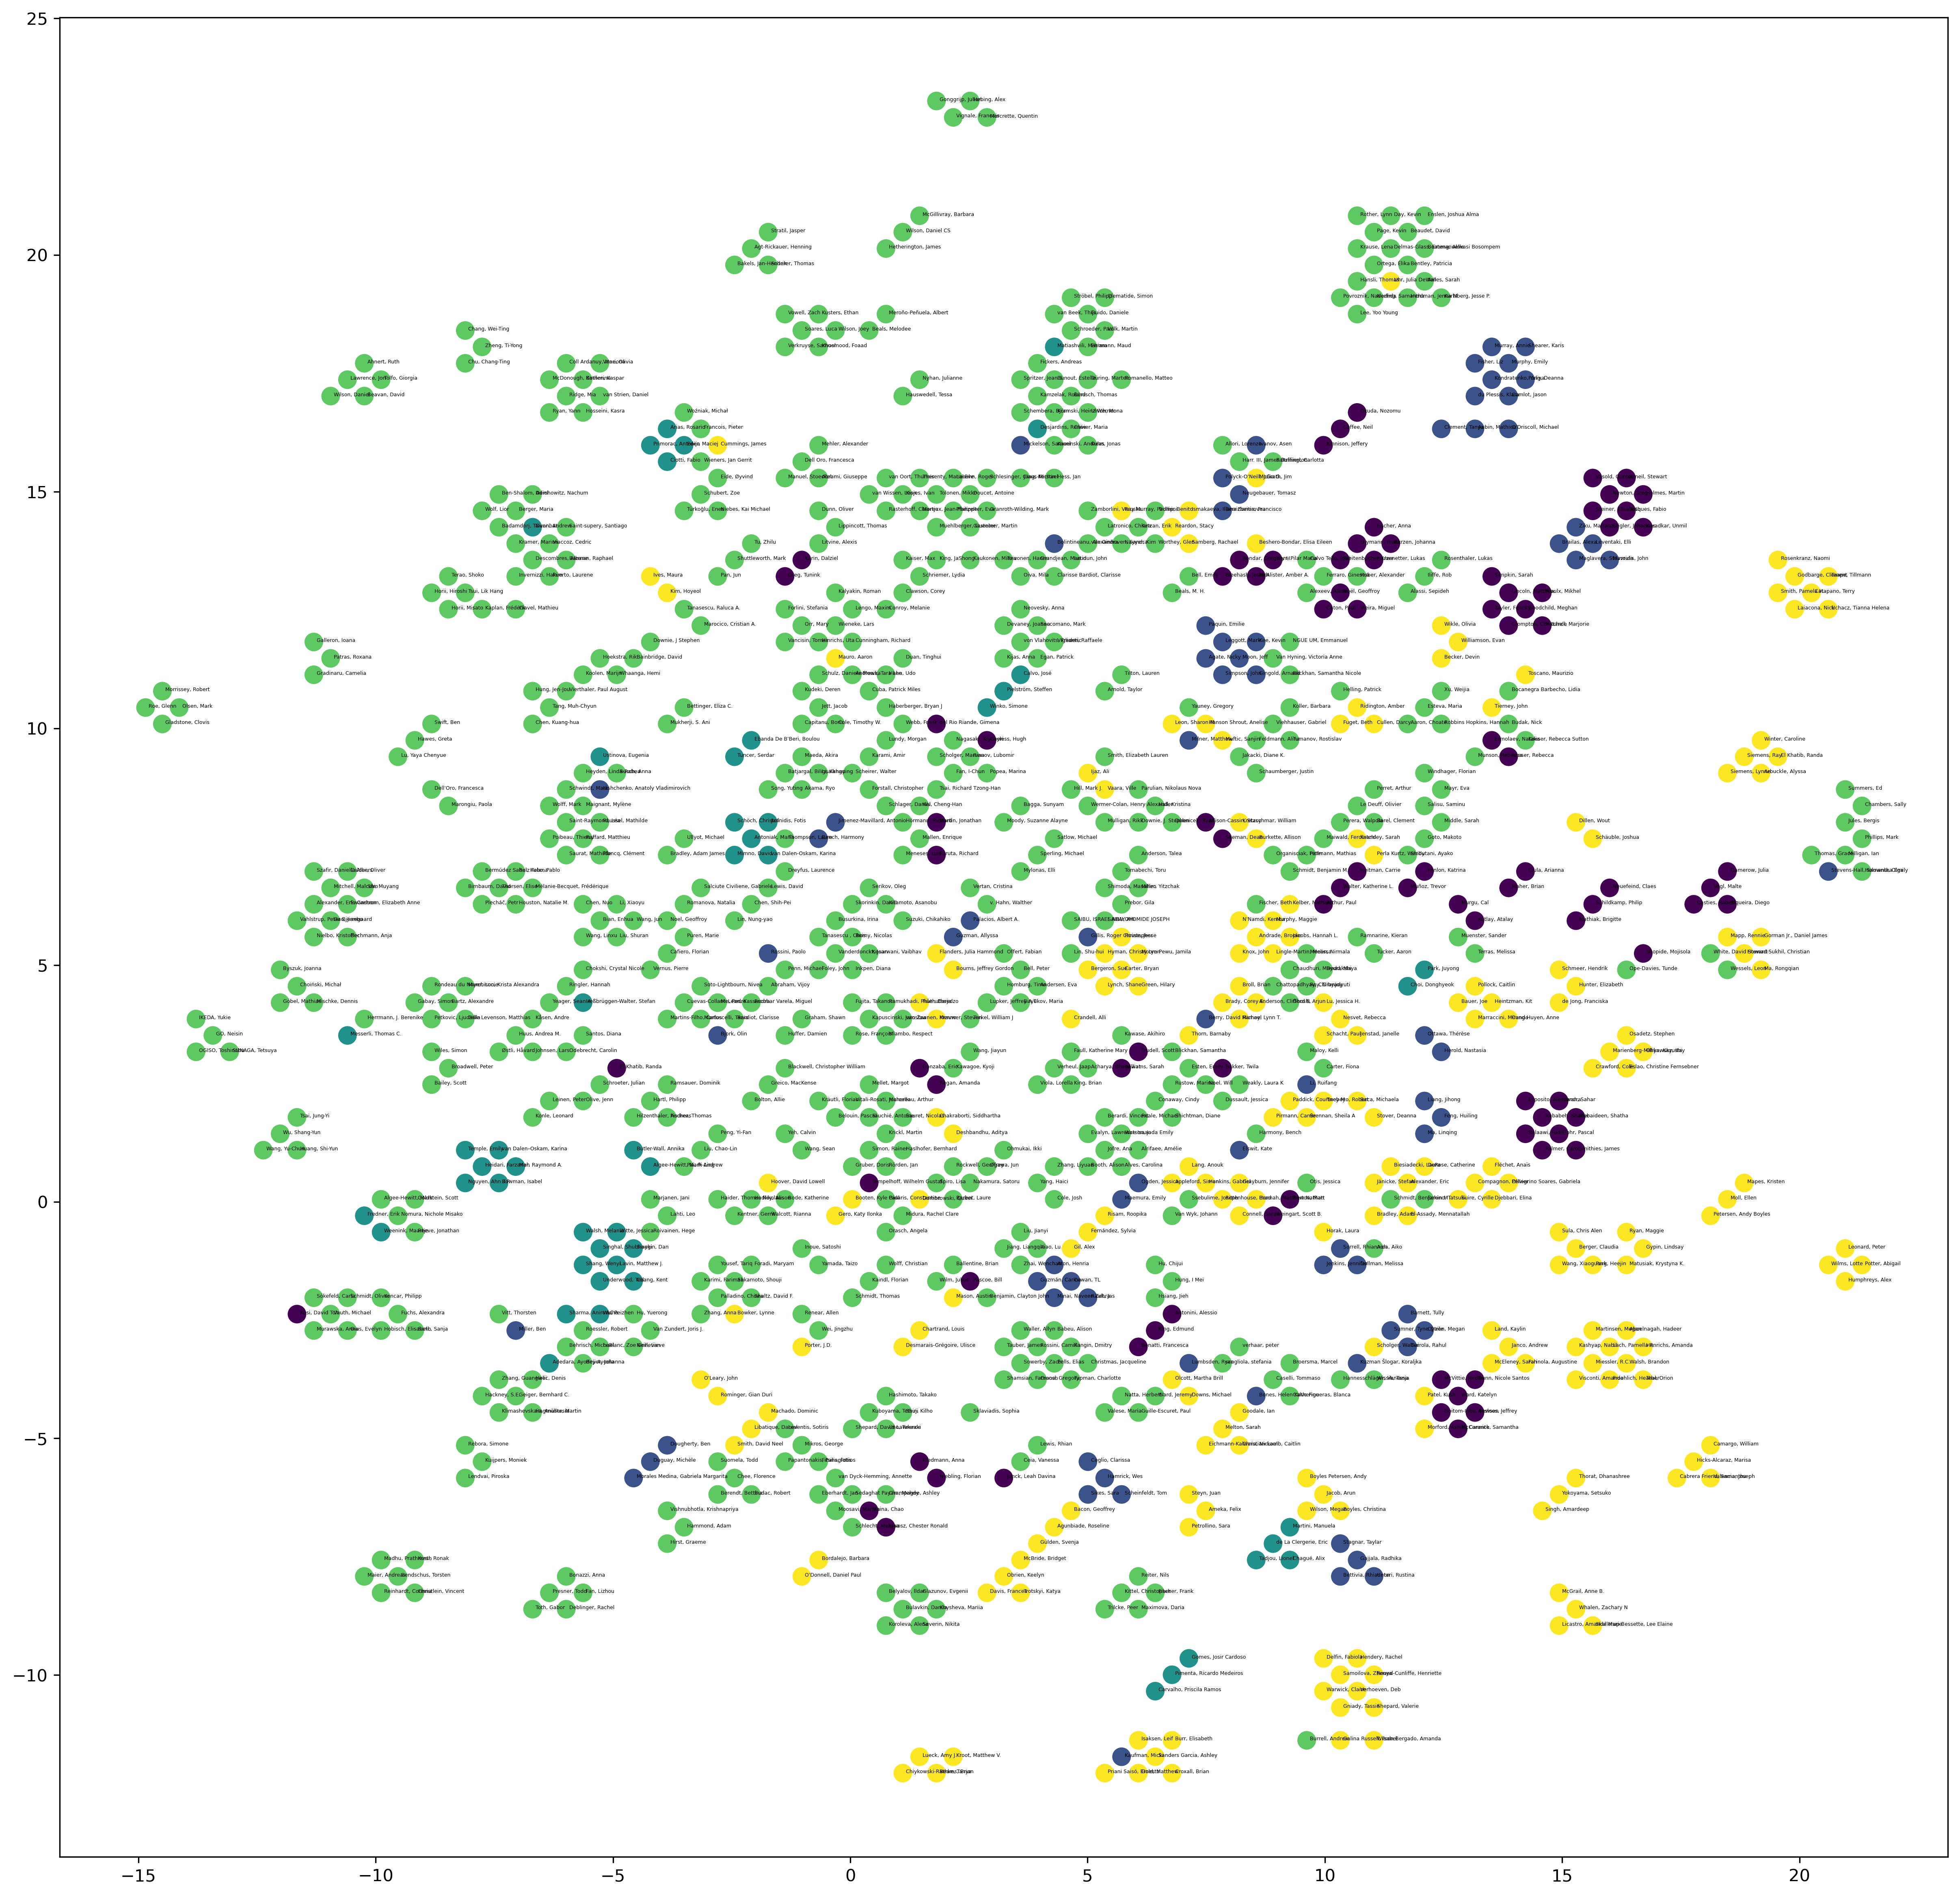

In [115]:
# UMAP

reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=.001, metric='cosine')
# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=100, c=topics)

for i, txt in enumerate(authors):
    text = plt.annotate(' ' + authors[i], (x[i] + .03, y[i]))
    text.set_fontsize(3)
    

In [116]:
pairs = []

i = 0

while len(pairs) == 0:
    i += .05
    
    for indexA, a in enumerate(embedding):
        for indexB, b in enumerate(embedding):
            if indexB > indexA:
                distance = dist = math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)
                if 0 < distance and distance < i:
                    x = (b[0] + a[0]) / 2
                    y = (b[1] + a[1]) / 2
                    
                    intersection = list(set(lemmas[indexA]) & set(lemmas[indexB]))

                    wordfreq = []
                    for lemma in intersection:
                        wordfreq.append([lemma, lemmas[indexA].count(lemma) + lemmas[indexA].count(lemma)])
                    
                    wordfreq.sort(key=lambda x:x[1])
                    wordfreq.reverse()

                    pairs.append([x,y, [i[0] for i in wordfreq[:3]] ])


print(len(pairs), 'lexical pairs')
pairs[0]


1027 lexical pairs


[16.529830932617188, -2.894648790359497, ['student', 'learning', 'education']]

In [117]:
# Clustering on embedding

import hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=.2)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=7)
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters
clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

len(clusters)

36

In [118]:
# Save files

json.dump(embedding.tolist(), codecs.open('../src/data/embedding.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(authors, codecs.open('../src/data/authors.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(lemmas, codecs.open('../src/data/lemmas.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(pairs, codecs.open('../src/data/pairs.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(topics, codecs.open('../src/data/topics.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(clusters, codecs.open('../src/data/clusters.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

In [119]:
# Word clouds for clusters

from planar import Polygon
from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate


for index, cluster in enumerate(clusters):

    scale = 100
    
    min_X = int(min([i[0] for i in embedding[cluster]]) * scale)
    max_X = int(max([i[0] for i in embedding[cluster]]) * scale)
    min_Y = int(min([i[1] for i in embedding[cluster]]) * scale)
    max_Y = int(max([i[1] for i in embedding[cluster]]) * scale)

    width = max_X - min_X; height = max_Y - min_Y
    
    points = list(map(lambda i: (int(i[0] * scale - min_X), int(i[1] * scale - min_Y)), embedding[cluster]))

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text = text + lemmas[id]
    text = ' '.join(map(str, text))
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')

    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.01)


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (255, 255, 255),
        font_path = path.join('Lato-Regular.ttf'),
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        # max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    wc.to_file(path.join("../src/data/wordclouds/" + f"{index:02}" + ".png")) # store to file

    

0 6 - 1 8 - 2 3 - 3 1 - 4 4 - 5 3 - 6 2 - 7 2 - 8 2 - 9 7 - 10 5 - 11 3 - 12 4 - 13 4 - 14 4 - 15 2 - 16 5 - 17 3 - 18 5 - 19 7 - 20 4 - 21 4 - 22 2 - 23 6 - 24 5 - 25 5 - 26 2 - 27 4 - 28 5 - 29 6 - 30 4 - 31 2 - 32 3 - 33 6 - 34 5 - 35 2 - 